### Load input data

In [1]:
import pandas as pd

data = ["est_hourly", "est_daily", "emp_hourly", "emp_daily"]
dfs = {
    name: pd.read_csv(f"data/data_{name}.csv.bz2", index_col=0, parse_dates=True)
    for name in data
}

### Group message types with negligible contribution to network traffic into 'other' type

- Add `inout` column, corresponding to the sum of the `in` and `out` flows
- Group messages types whose maximum `inout` traffic contribution across the measurement period is below a certain threshold
- Add normalized versions of the `in` and `out` columns

In [2]:
def recategorize_by_threshold(df_orig: pd.DataFrame, threshold: float) -> pd.DataFrame:
    """
    1. Compute the maximum 'inout' value for each msg_type across the entire dataset.
    2. Determine which msg_types exceed the threshold (keep_types).
    3. For sub-threshold msg_types, group by 'timestamp' to sum 'in', 'out', and 'inout'.
    4. Return a new DataFrame with columns [timestamp, msg_type, in, out, inout].
    """
    max_inout_by_type = df.groupby("msg_type")["inout"].max()
    keep_types = max_inout_by_type[max_inout_by_type > threshold].index
    df_keep = df[df["msg_type"].isin(keep_types)].copy()
    df_other = df[~df["msg_type"].isin(keep_types)].copy()
    df_keep.reset_index(inplace=True)
    df_other.reset_index(inplace=True)
    df_other_agg = df_other.groupby("timestamp", as_index=False)[
        ["in", "out", "inout"]
    ].sum()
    df_other_agg["msg_type"] = "other"
    result_df = pd.concat([df_keep, df_other_agg], ignore_index=True)
    result_df.sort_values(by=["timestamp", "msg_type"], inplace=True)
    return result_df[["timestamp", "msg_type", "in", "out", "inout"]]


thresholds = {
    "est_daily": 50_000_000,
    "est_hourly": 5_000_000,
}

for name, threshold in thresholds.items():
    df = dfs[name]
    df["inout"] = df["in"] + df["out"]
    df = recategorize_by_threshold(df, threshold)
    df["in_norm"] = df["in"] / df["inout"]
    df["out_norm"] = df["out"] / df["inout"]
    dfs[name] = df

dfs["emp_hourly"]["inout"] = dfs["emp_hourly"]["in"] + dfs["emp_hourly"]["out"]
dfs["emp_daily"]["inout"] = dfs["emp_daily"]["in"] + dfs["emp_daily"]["out"]

# Validation

### Hourly (IBD)

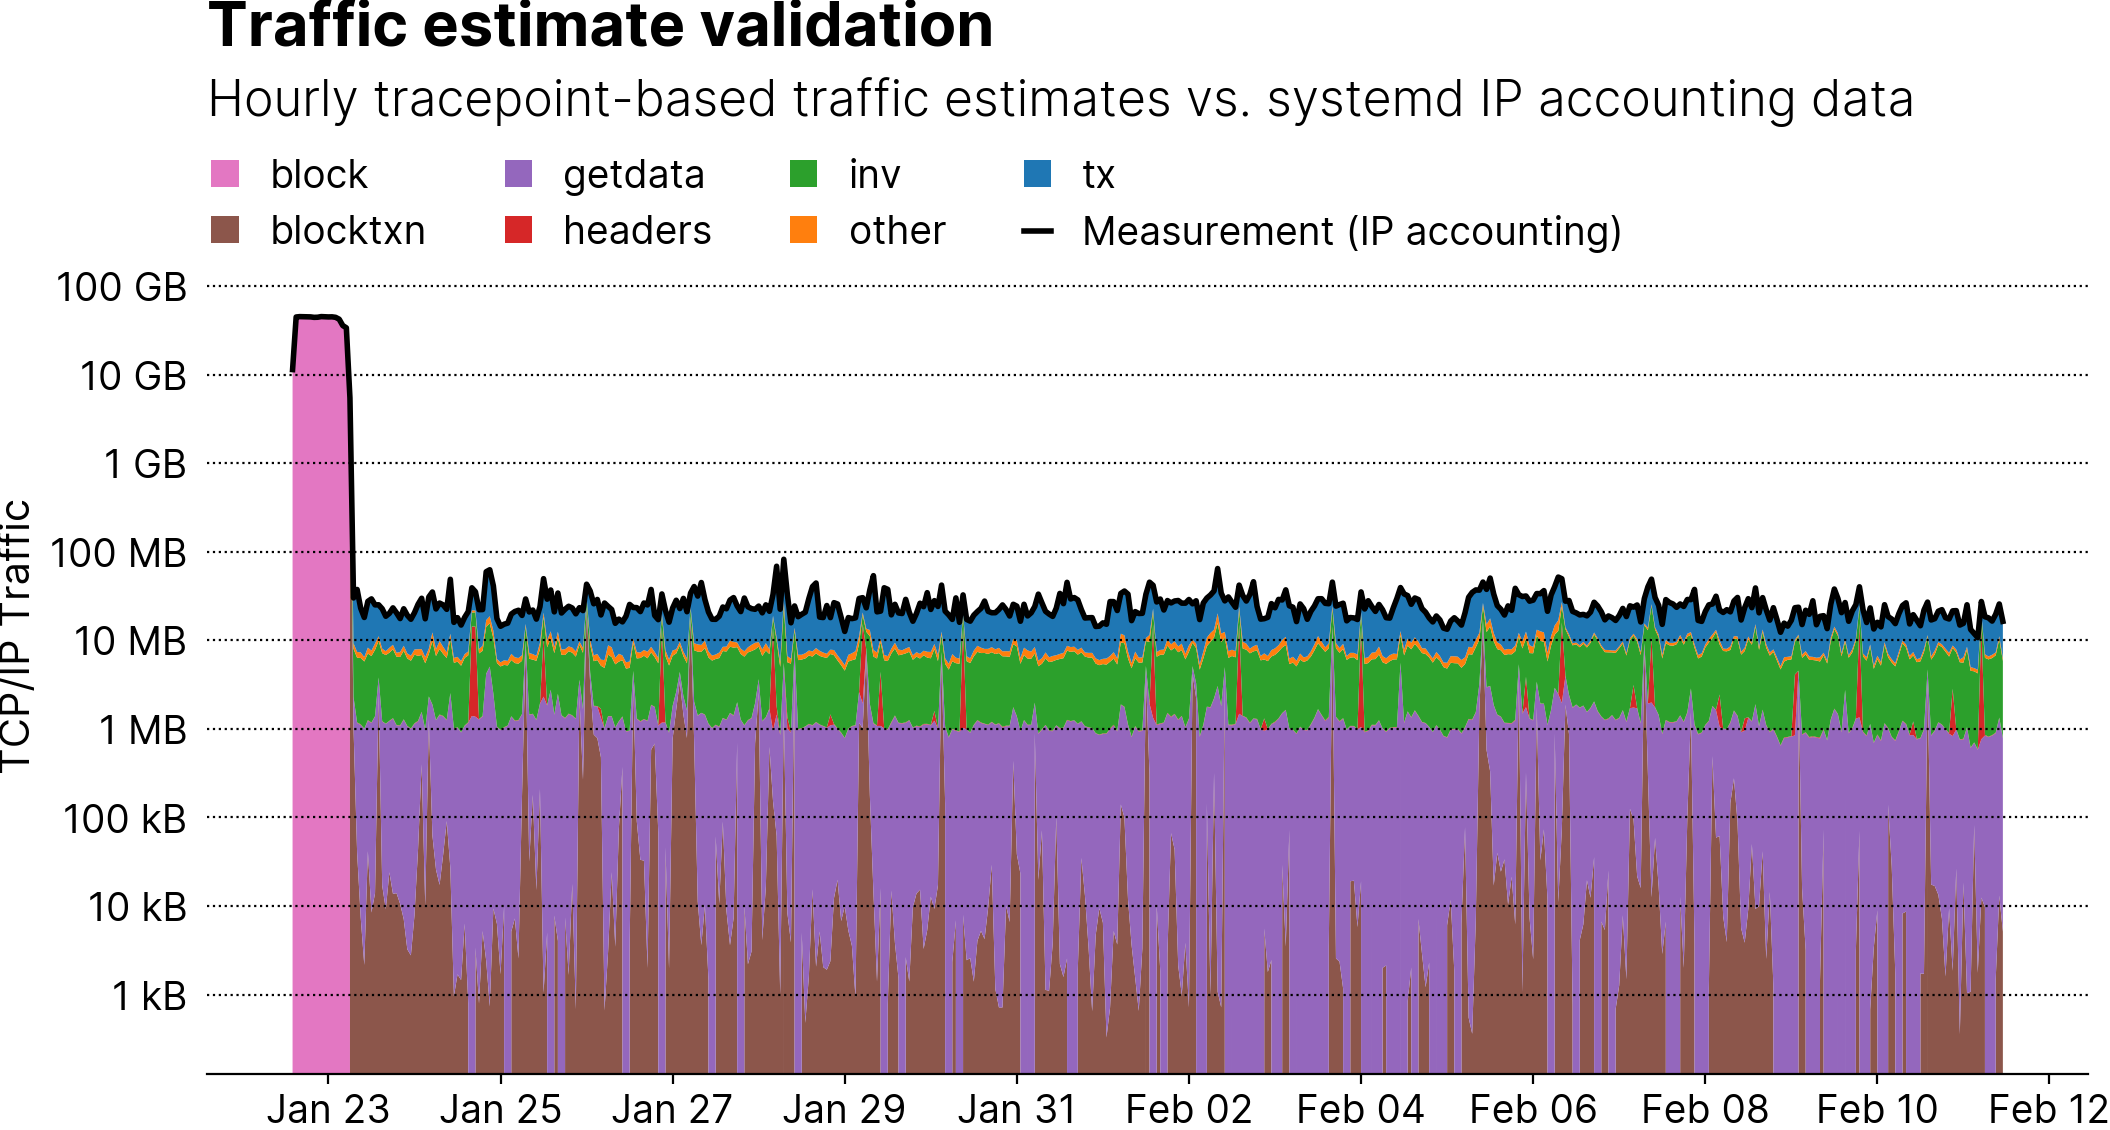

In [3]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter


df_est = dfs["est_hourly"].copy()
df_pivot = df_est.pivot(index="timestamp", columns="msg_type", values="inout").fillna(0)

fig, ax = plt.subplots()

msg_types = df_pivot.columns
num_msg_types = len(msg_types)
tab10 = plt.get_cmap("tab10")
colors = [tab10(i % 10) for i in range(num_msg_types)][::-1]
colors = {msg_type: color for msg_type, color in zip(msg_types, colors)}

ax.stackplot(
    df_pivot.index,
    *[df_pivot[col] for col in df_pivot.columns],
    labels=df_pivot.columns,
    colors=[colors[col] for col in df_pivot.columns],
)
emp_line = dfs["emp_hourly"]["inout"]
ax.plot(
    dfs["emp_hourly"].index,
    emp_line,
    color="black",
    linewidth=2,
    label="Measurement (IP accounting)",
)

fig.suptitle("Traffic estimate validation")
ax.set_title("Hourly tracepoint-based traffic estimates vs. systemd IP accounting data")
ax.set_ylabel("TCP/IP Traffic")
ax.legend(ncol=4, title="")
ax.set_yscale("log")
ax.set_ylim(ymax=999 * 10**9)
formatter = EngFormatter(unit="B")
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))

plt.tight_layout()
plt.show()

# Daily

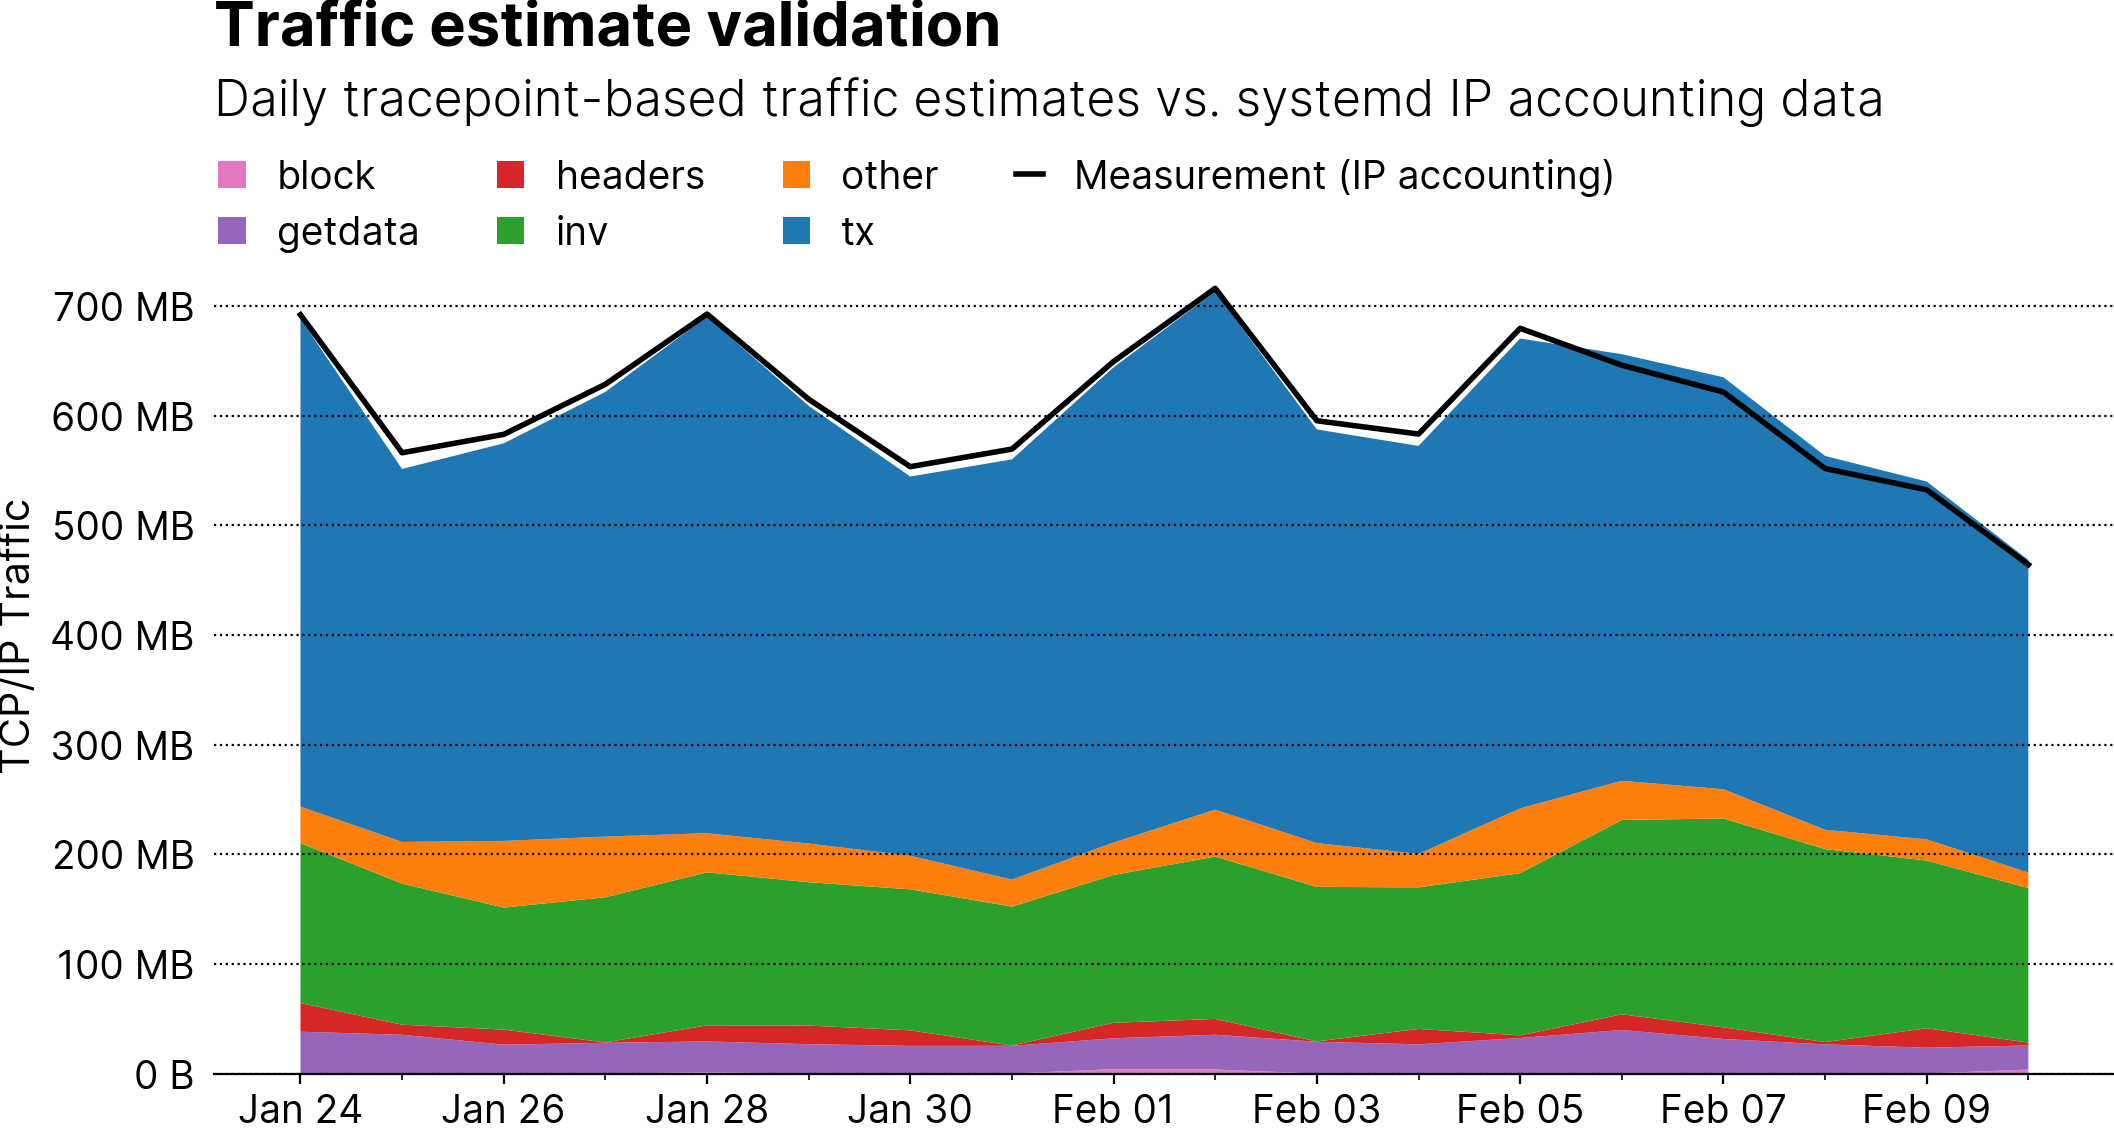

In [4]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter


df_est = dfs["est_daily"].copy()
df_pivot = df_est.pivot(index="timestamp", columns="msg_type", values="inout").fillna(0)
start_date = df_pivot.index.unique()[2]
stop_date = df_pivot.index.unique()[-2]
df_pivot = df_pivot[start_date:stop_date]  # remove IBD phase and data from last day

fig, ax = plt.subplots()

ax.stackplot(
    df_pivot.index,
    *[df_pivot[col] for col in df_pivot.columns],
    labels=df_pivot.columns,
    colors=[colors[col] for col in df_pivot.columns],
)
emp_line = dfs["emp_daily"]["inout"]
emp_line = emp_line[start_date:stop_date]  # remove IBD phase and data from last day
ax.plot(
    emp_line.index,
    emp_line,
    color="black",
    linewidth=2,
    label="Measurement (IP accounting)",
)

fig.suptitle("Traffic estimate validation")
ax.set_title("Daily tracepoint-based traffic estimates vs. systemd IP accounting data")
ax.set_ylabel("TCP/IP Traffic")
ax.legend(ncol=4, title="")
ax.set_ylim(ymax=799 * 10**6)
formatter = EngFormatter(unit="B")
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))

plt.tight_layout()
plt.show()

## Daily share breakdown

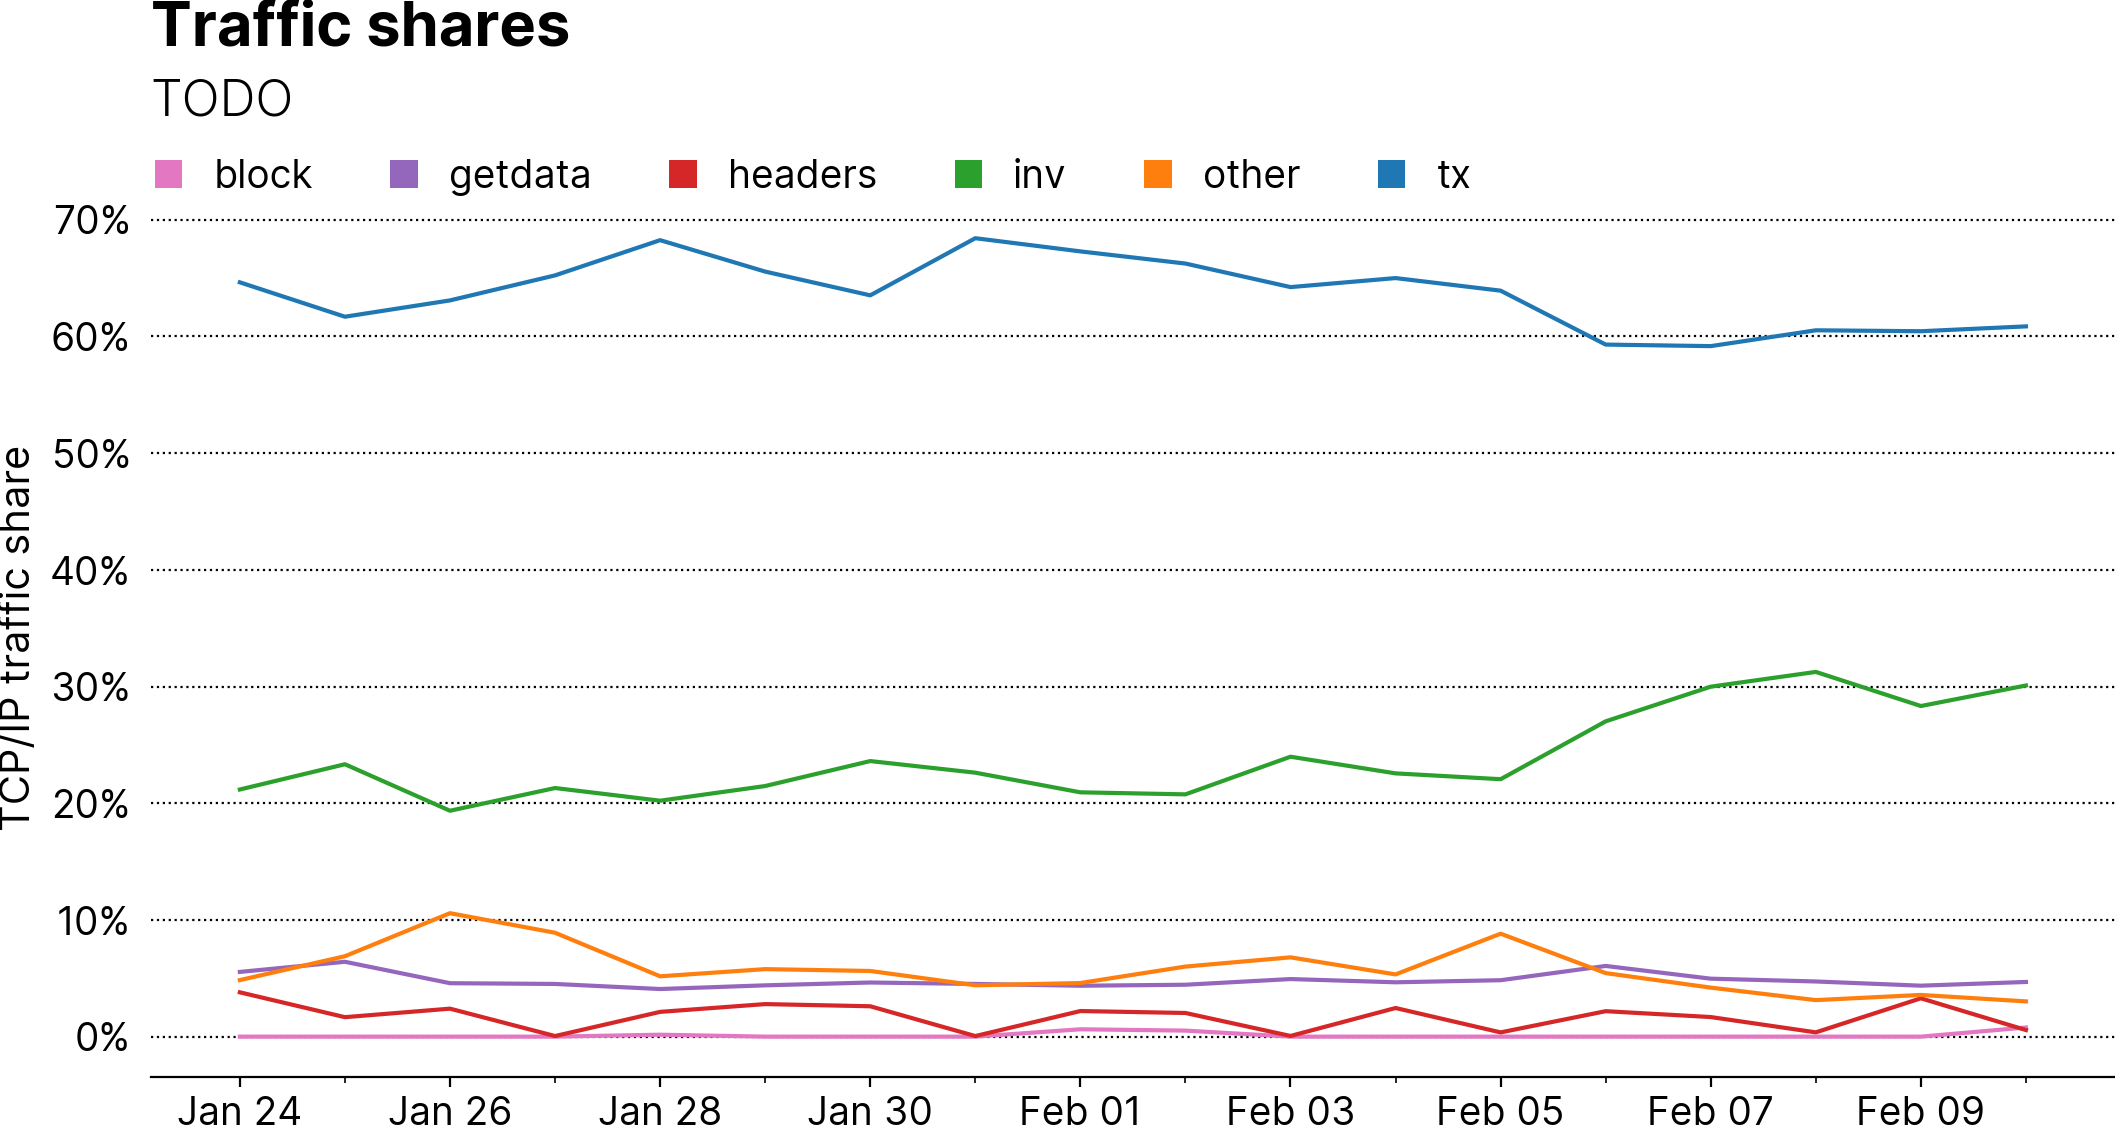

In [21]:
import matplotlib.ticker as mtick


df_shares = df_pivot.div(df_pivot.sum(axis=1), axis=0)
df_shares

fig, ax = plt.subplots()

for col in df_shares.columns:
    ax.plot(df_shares.index, df_shares[col], label=col, color=colors[col])

# 4. Customize the plot
fig.suptitle("Traffic shares")
ax.set_title("TODO")
ax.set_ylabel("TCP/IP traffic share")  # or "Share (%)" if you multiplied by 100
ax.legend()

ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))


plt.tight_layout()
plt.show()